In [1]:
adfile_path = r"C:\Users\21lyb\Downloads\PBMC_simulated_cnas_041025.h5ad"

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
from biomart import BiomartServer
from io import StringIO
import anndata as ad
import warnings

warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

sc.logging.print_header()

Package,Version
numpy,2.0.1
pandas,2.2.3
scanpy,1.11.1
infercnvpy,0.6.0
matplotlib,3.10.0
biomart,0.9.2
anndata,0.11.4
Component,Info
Python,"3.11.11 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:34:19) [MSC v.1929 64 bit (AMD64)]"
OS,Windows-10-10.0.26100-SP0


In [ ]:
# Functions
def qc(adata,
    mt_threshold_pct=20,
    min_genes=200,
    max_counts=50000,
    min_cells=3):

    adata1 = adata.copy()

    # Find MT genes
    adata1.var['mt'] = adata1.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'],
                            percent_top=None,
                            log1p=False,
                            inplace=True)

    # Filter out cells based on MT genes
    adClean = adata1[adata1.obs['pct_counts_mt']<mt_threshold_pct,:].copy()

    # Filter out cells based on number of genes expressed
    sc.pp.filter_cells(adClean, min_genes=min_genes)

    # Filter out cells based on total counts
    sc.pp.filter_cells(adClean, max_counts=max_counts)

    # Filter out genes expressed in few cells
    sc.pp.filter_genes(adClean, min_cells=min_cells)

    return adClean

def preprocess(adata,
               min_mean=0.0125,
               max_mean=6,
               min_disp=0.25):
    
    adNorm = adata.copy()

    # Normalize and log transform
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Detect highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)

    # PCA
    sc.tl.pca(adata, use_highly_variable=True)
    sc.pl.pca_variance_ratio(adata,50)

    return adNorm

def KNN(adata, n_neighbors=20, n_pcs=10):
    sc.pp.neighbors(adata,n_neighbors=n_neighbors,n_pcs=n_pcs)

def downsample(adata,n_cells=2000):
    if adata.n_obs <= n_cells:
        return adata
    else:
        return adata[np.random.choice(adata.obs_names, n_cells, replace=False), :].copy()

def fetch_positions(adata):
    # Connect to Ensembl Biomart server
    server = BiomartServer("http://grch37.ensembl.org/biomart")
    dataset = server.datasets['hsapiens_gene_ensembl']

    # Query gene names for only missing gene positions
    no_positions = adata[:, adata.var[['start', 'end']].isna().any(axis=1)]
    with_positions = adata[:, ~adata.var[['start', 'end']].isna().any(axis=1)]
    response = dataset.search({
        'filters':{'ensembl_gene_id':list(no_positions.var['gene_ids'])},
        'attributes':['ensembl_gene_id','chromosome_name','start_position','end_position','strand']
    })

    # Convert response to DataFrame and merge with adata.var if response is successful
    if response.status_code == 200:
        print("Request successful!")
        gene_annotations_df = pd.read_csv(StringIO(response.text),sep='\t',header=None)
        gene_annotations_df.columns = ['gene_name','chromosome','start','end','strand']
    else:
        print(f"Request failed with status code: {response.status_code}")
        print(response.text)

    # Isolate fetched genes from BioMart in no_positions adata
    fetched_positions = no_positions[:, no_positions.var['gene_ids'].isin(gene_annotations_df['gene_name'])].copy()

    # Sort fetched genes based on ensembl gene IDs
    fetched_positions = fetched_positions[:, fetched_positions.var['gene_ids'].argsort()].copy()

    # Add the fetched gene positions to the adata
    fetched_positions.var['chromosome'] = gene_annotations_df['chromosome'].values
    fetched_positions.var['start'] = gene_annotations_df['start'].values
    fetched_positions.var['end'] = gene_annotations_df['end'].values
    fetched_positions.var['strand'] = gene_annotations_df['strand'].values

    # Concatenate fetched genes with isolated genes already with positions
    adClean = ad.concat([with_positions, fetched_positions], axis=1)

    # Include obs into the cleaned adata
    adClean.obs = with_positions.obs.copy()

    return adClean

def standardize_chromosomes(adata):
    
    adata1 = adata.copy()

    # Add 'chr' prefix to chromosome names
    adata1.var['chromosome'] = 'chr' + adata1.var['chromosome'].astype(str)

    # Define standard chromosome names with 'chr' prefix
    standard_chromosomes = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY', 'chrMT']

    # Filter adata to include only genes on standard chromosomes
    adata1 = adata1[:, adata1.var['chromosome'].isin(standard_chromosomes)].copy()

    return adata1

def infer_cnas(adata,reference_key='cell_type',reference_cat=[]):

    # Check if reference categories are provided, if not, use unique categories from the adata
    if len(reference_cat) == 0:
        reference_cat = list(adata.obs[reference_key].unique())

    # Run infercnvpy
    cnv.tl.infercnv(adata,reference_key=reference_key,reference_cat=reference_cat)

In [4]:
adata = sc.read_h5ad(adfile_path)

In [5]:
# adata = qc(adata)

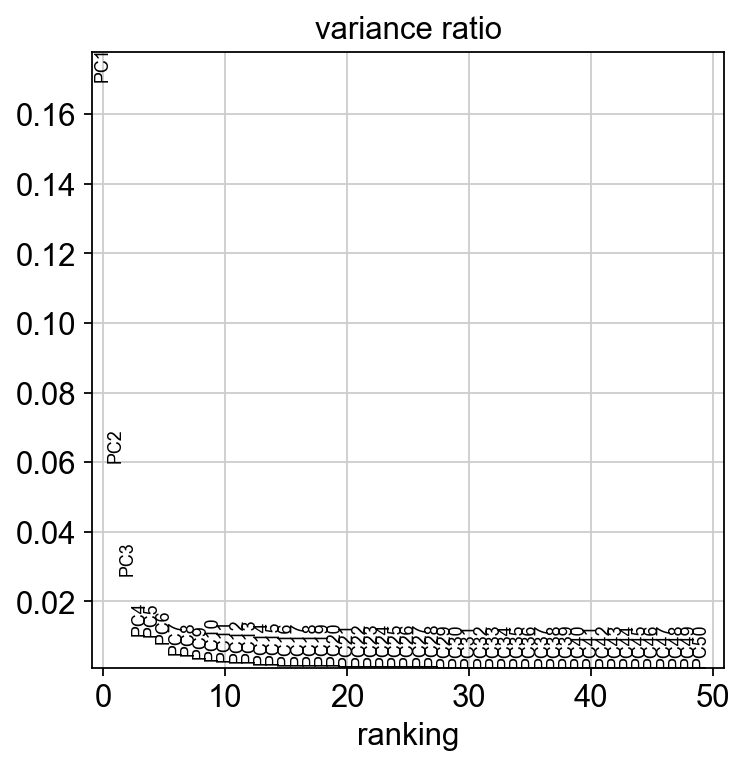

In [6]:
adata = preprocess(adata)

In [7]:
KNN(adata,n_pcs=10)

In [8]:
# adata = downsample(adata,n_cells=2000)

In [9]:
adata = fetch_positions(adata)

Request successful!


In [10]:
adata = standardize_chromosomes(adata)

In [ ]:
infer_cnas(adata,reference_key='cell_type')

  0%|          | 0/3 [00:00<?, ?it/s]